<a href="https://colab.research.google.com/github/eunzzae/Study_DS/blob/main/13)_%EB%A7%A4%EC%9E%A5_%EB%B0%A9%EB%AC%B8_%ED%98%BC%EC%9E%A1%EB%8F%84_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 매장 방문 혼잡도 예측
>**목차**

* 문제상황 및 데이터 살펴보기  
* 문제해결 프로세스 정의  
1) 요일별 특성 파악  
2) 메뉴 데이터 처리  
3) 식수 인원 예측

In [1]:
# 한글 폰트 설치 후 런타임 재시작
!pip install pingouin
!pip install scipy
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [4]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# # ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter13')
# # '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter13' ← 변경X
# os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 문제상황 및 데이터 살펴보기
---
>**시나리오**

```
A매장 관리자는 요즘 음식 재고로 인하여 골치를 썩고 있다. 매번 식수를 예측하지만 어떤 날은 적게,  
어떤 날은 많게 오는 경우가 허다하여 재고관리측면에서 손실을 보고 있다.  
메뉴 정보와 근무자의 정보 Data를 활용하여 식수를 예측하고 재고를 효율적으로 관리하려고 한다.

```  

>**데이터 살펴보기**

* 본사 근무자 현황과 식사메뉴 데이터  
* 데이터 명세  

|일자|요일|본사 정원수|본사 휴가자수|본사 출장자수|본사 시간외근무 명령서 승인건수|
|:---:|:---:|:---:|:---:|:---:|:---:|
|현 본사 소속 재택근무자수|조식메뉴|중식메뉴|석식메뉴|중식계|석식계|


In [5]:
# Data read
import pandas as pd
bath = '/content/drive/MyDrive/[STUDY] 데이터사이언스/데이터분석/data/chapter13_매장 방문 혼잡도 예측/'
df = pd.read_csv(bath + 'chapter13_congestion.csv', encoding='cp949')
df.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


## 문제해결 프로세스 정의
---
>**문제정의**

```
- 식수 예측 어려움으로 인한 재고관리 손실 비용
```

>**기대효과**

```
- 식수 인원 예측을 통한 재고관리 효율화, 손실 비용 감소
```

>**해결방안**

```
- 식수 예측 모델 활용 식수 인원 예측 및 음식 준비
1) Data 전처리 및 식수인원 Data 탐색  
2) Text(메뉴) Data 처리 방법 및 탐색  
3) ML 알고리즘을 활용하여 식수인원 예측
```

>**성과측정**

```
- 전/후 손실 비용 비교
```

>**현업적용**

```
- Model에 Input하기 위한 Data mart 준비(주단위, 월단위)
- Model을 활용하여 예상 식수 인원 예측
- 식수 인원에 맞춰 재고 관리
```

## Session 1  
## 요일별 특성 파악  

### Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인

In [6]:
# Data shape
# 1205 row, 12col 구성됨
print('df', df.shape)

df (1205, 12)


In [7]:
# Data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [8]:
# Null 값
df.isnull().sum()

일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
조식메뉴              0
중식메뉴              0
석식메뉴              0
중식계               0
석식계               0
dtype: int64

### Data 탐색
---

In [9]:
df.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [10]:
import datetime
df['일자'] = pd.to_datetime(df['일자'])

In [11]:
# 2016년 2월 1일 ~ 2021년 1월 26일
df['일자'].min(), df['일자'].max()

(Timestamp('2016-02-01 00:00:00'), Timestamp('2021-01-26 00:00:00'))

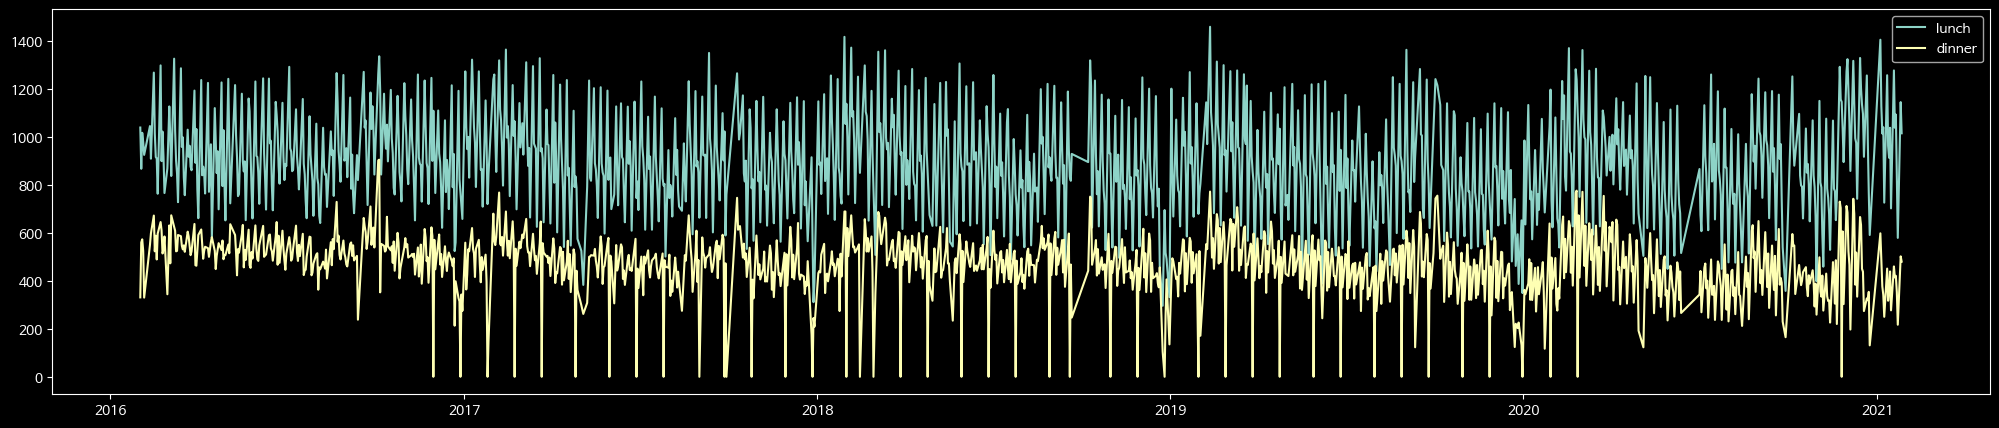

In [12]:
# 일자별 식수
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])

plt.plot(df['일자'], df['중식계'], label='lunch');
plt.plot(df['일자'], df['석식계'], label='dinner');
plt.gcf().set_size_inches(25,5);
plt.legend();

In [13]:
df_dow = pd.DataFrame(df.groupby('요일')[['중식계', '석식계']].mean())
df_dow

,중식계,석식계
요일,,
금,653.609959,404.979253
목,823.991803,480.401639
수,905.213389,363.615063
월,1144.331950,538.933610
화,925.620833,520.129167


In [14]:
# 그래프에 표현하기 위해 index의 순서를 요일 순서대로 정렬
df_dow = pd.DataFrame(df_dow, index=['월', '화','수','목','금'])
df_dow

,중식계,석식계
월,1144.331950,538.933610
화,925.620833,520.129167
수,905.213389,363.615063
목,823.991803,480.401639
금,653.609959,404.979253


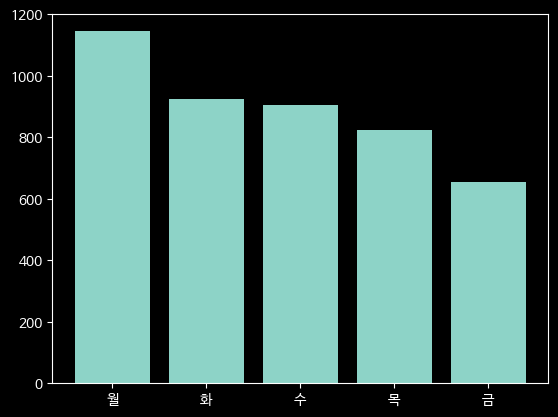

In [15]:
# 요일별 평균 식수(중식계)

fig, ax = plt.subplots()
plt.bar(df_dow.index, df_dow['중식계']);


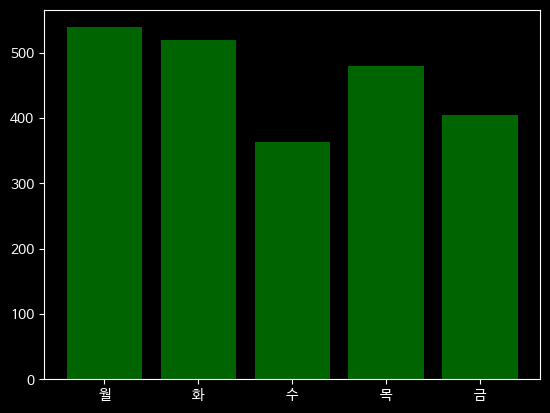

In [16]:
# 요일별 평균 식수(석식계)

fig, ax = plt.subplots()
plt.bar(df_dow.index, df_dow['석식계'], color='darkgreen');

# xlabels= ['mon', 'tue', 'wed','thr', 'fri']
# ax.set_xticklabels(xlabels);

In [17]:
df.head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0


In [18]:
df['month']=df['일자'].dt.month
df.head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,month
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2


In [19]:
df_month = df.groupby('month')[['중식계','석식계']].mean()
df_month['index'] = df_month.index.astype(str)
df_month.head(3)

,중식계,석식계,index
month,,,
1,934.247525,424.564356,1
2,989.623656,514.860215,2
3,953.607477,530.700935,3


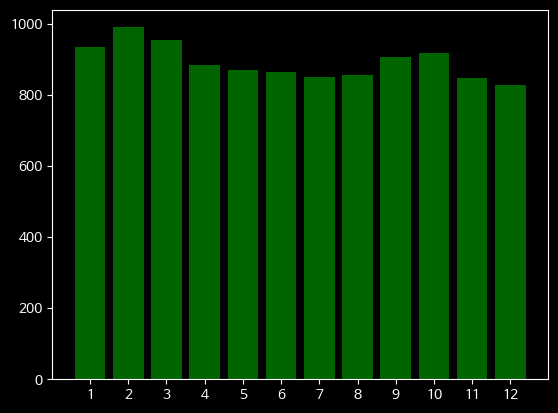

In [20]:
# 월 별 평균 식수(중식계)
fig, ax = plt.subplots()
plt.bar(df_month['index'], df_month['중식계'], color='darkgreen');

<BarContainer object of 12 artists>

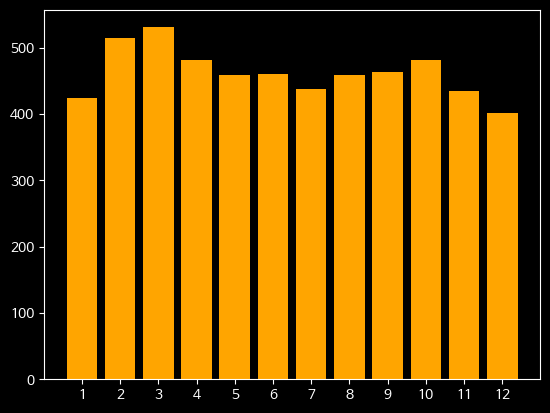

In [21]:
fig, ax = plt.subplots()
plt.bar(df_month['index'], df_month['석식계'], color='orange')

## Session 2  
## 메뉴 데이터 처리  
* 메뉴인 Text 데이터를 활용하기 위한 데이터 처리

### Text data split
---

In [22]:
# 메뉴 데이터가 공백으로 나뉘어져 있음
df['조식메뉴'][0]

'모닝롤/찐빵  우유/두유/주스 계란후라이  호두죽/쌀밥 (쌀:국내산) 된장찌개  쥐어채무침  포기김치 (배추,고추가루:국내산) '

In [23]:
# 공백도 2칸과 1칸으로 비균일하게 나뉘어져 있음
print(df['조식메뉴'][0].replace(' ', '*'))

모닝롤/찐빵**우유/두유/주스*계란후라이**호두죽/쌀밥*(쌀:국내산)*된장찌개**쥐어채무침**포기김치*(배추,고추가루:국내산)*


In [24]:
# 공백2를 공백 1로 변경
df['조식메뉴']= df['조식메뉴'].str.replace('  ', ' ')
df['중식메뉴']=df['중식메뉴'].str.replace('  ', ' ')
df['석식메뉴']=df['석식메뉴'].str.replace('  ', ' ')

In [25]:
df['조식메뉴'][0]

'모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐어채무침 포기김치 (배추,고추가루:국내산) '

In [26]:
# 공백으로 데이터를 split
df['조식메뉴'].str.split(' ')

0       [모닝롤/찐빵, 우유/두유/주스, 계란후라이, 호두죽/쌀밥, (쌀:국내산), 된장찌...
1       [모닝롤/단호박샌드, 우유/두유/주스, 계란후라이, 팥죽/쌀밥, (쌀:국내산), 호...
2       [모닝롤/베이글, 우유/두유/주스, 계란후라이, 표고버섯죽/쌀밥, (쌀:국내산), ...
3       [모닝롤/토마토샌드, 우유/두유/주스, 계란후라이, 닭죽/쌀밥, (쌀,닭:국내산),...
4       [모닝롤/와플, 우유/두유/주스, 계란후라이, 쇠고기죽/쌀밥, (쌀:국내산), 재첩...
                              ...                        
1200    [모닝롤/페퍼로니피자, 우유/주스, 계란후라이/찐계란, 크루통크림스프/흑미밥, 아귀...
1201    [모닝롤/생크림단팥빵, 우유/주스, 계란후라이/찐계란, 누룽지탕/흑미밥, 떡국, 해...
1202    [모닝롤/BLT샌드위치, 우유/주스, 계란후라이/찐계란, 흑임자죽/흑미밥, 바지락살...
1203    [모닝롤/호박고구마오븐구이, 우유/주스, 계란후라이/찐계란, 누룽지탕/흑미밥, 감자...
1204    [모닝롤/야채샌드, 우유/주스, 계란후라이/찐계란, 참치죽/흑미밥, 홍합탕, 애호박...
Name: 조식메뉴, Length: 1205, dtype: object

In [27]:
# 공백으로 나눈 데이터중 첫번째 list만 가져와서 main 메뉴로 활용
df['조식메뉴'].str.split(' ').str[0]

0              모닝롤/찐빵
1           모닝롤/단호박샌드
2             모닝롤/베이글
3           모닝롤/토마토샌드
4              모닝롤/와플
            ...      
1200       모닝롤/페퍼로니피자
1201       모닝롤/생크림단팥빵
1202      모닝롤/BLT샌드위치
1203    모닝롤/호박고구마오븐구이
1204         모닝롤/야채샌드
Name: 조식메뉴, Length: 1205, dtype: object

In [28]:
# 왼쪽 공백을 제거
df['조식메뉴'] = df['조식메뉴'].str.lstrip()
df['중식메뉴']=df['중식메뉴'].str.lstrip()
df['석식메뉴']=df['석식메뉴'].str.lstrip()

In [29]:
df['조식메뉴_main'] = df['조식메뉴'].str.split(' ').str[0]
df['중식메뉴_main'] = df['중식메뉴'].str.split(' ').str[0]
df['석식메뉴_main'] = df['석식메뉴'].str.split(' ').str[0]

In [30]:
df.head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,month,조식메뉴_main,중식메뉴_main,석식메뉴_main
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐어채무...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 포기김...",1039.0,331.0,2,모닝롤/찐빵,쌀밥/잡곡밥,쌀밥/잡곡밥
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌개 ...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무침...",867.0,560.0,2,모닝롤/단호박샌드,쌀밥/잡곡밥,콩나물밥*양념장
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국 느...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 견...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기전...",1017.0,573.0,2,모닝롤/베이글,카레덮밥,쌀밥/잡곡밥


In [31]:
# main menu 가짓수 파악
df['조식메뉴_main'].value_counts().head(10)

조식메뉴_main
모닝롤/프렌치토스트    52
모닝롤/마늘빵       46
모닝롤/크로와상      45
모닝롤/찐빵        44
모닝롤/에그샌드      43
모닝롤/참치샌드      42
모닝롤/와플        41
모닝롤/야채샌드      41
모닝롤/씨크립샌드     40
모닝롤/단팥빵       40
Name: count, dtype: int64

In [32]:
# main menu 가짓수 파악
df['중식메뉴_main'].value_counts().head(10)

중식메뉴_main
쌀밥/잡곡밥         879
쌀밥/흑미밥/찰현미밥     74
콩나물밥            23
카레덮밥            18
나물비빔밥           15
곤드레밥*강된장        12
단호박영양밥          10
쌀밥/수수밥/찰현미밥     10
곤드레밥*양념장         8
김치제육덮밥           8
Name: count, dtype: int64

In [33]:
# main menu 가짓수 파악
df['석식메뉴_main'].value_counts().head(10)

석식메뉴_main
쌀밥/잡곡밥    657
흑미밥        92
*          28
김밥         25
유부초밥       25
오므라이스      22
멸치주먹밥      21
참치주먹밥      18
충무김밥       16
김치볶음밥      15
Name: count, dtype: int64

### Menu data EDA
---

In [34]:
df['중식계'].mean()

890.3344398340249

In [35]:
# main menu에 따른 식수 인원
df_lunch = pd.DataFrame(df.groupby('중식메뉴_main')['중식계'].mean())
df_lunch.sort_values(by=['중식계'], ascending=True).head(10)

,중식계
중식메뉴_main,
파인애플볶음밥,387.0
베이컨김치볶음밥,505.0
돈육버섯고추장덮밥,516.0
야채볶음밥*짜장소스,535.0
김치볶음밥,543.0
쌀밥/병아리콩/찰현미밥,570.0
오므라이스,572.0
전주비빔밥*약고추장,579.0
쌀밥/옛날돈까스,586.0


In [36]:
df['석식계'].mean()

461.77261410788384

In [37]:
# main menu에 따른 식수 인원
# 석식메뉴가 없는 데이터도 존재함.
df_dinner = pd.DataFrame(df.groupby('석식메뉴_main')[['석식계']].mean())
df_dinner.sort_values(by=['석식계'], ascending=False).head(10)

,석식계
석식메뉴_main,
마파두부,685.0
마늘베이컨볶음밥,645.0
김밥/맑은국,645.0
참치덮밥,640.0
고추잡채덮밥,633.0
투움바스파게티,629.0
짜장면/작은밥,619.5
버섯영양밥*우렁양념장,614.0
토마토스파게티(작은밥),607.0


In [38]:
# 석식메뉴가 없는 데이터도 존재 (*, 자기계발의 날, *자기계발의날*, 가정의 날 등)
df[df['석식계']==0]['석식메뉴'].value_counts()

석식메뉴
*                                                       21
                                                         4
자기계발의날                                                   3
자기개발의날                                                   3
* 자기계발의날 *                                               2
* 자기개발의날 *                                               2
자기계발의날                                                   1
*자기계발의날*                                                 1
가정의날                                                     1
쌀밥/잡곡밥 (쌀:국내산) 된장찌개 미니함박조림 계란말이 비름나물 포기김치 (김치:국내산)       1
쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국 고추잡채*꽃빵 계란찜 오이무침 포기김치 (김치:국내산)      1
*                                                        1
* 자기개발의날 *                                               1
＜자기 계발의 날＞                                               1
Name: count, dtype: int64

## Session 3
## 식수 인원 예측

In [39]:
# 석식계 예측 시 제외 필요
len(df[df['석식계']==0])

43

### 모델링을 위한 데이터 준비
---

In [40]:
# numeric, categorical value 나누기
numeric_list = []
categorical_list = []

for i in df.columns:
    if df[i].dtypes == 'O':
        categorical_list.append(i)
    else:
        numeric_list.append(i)

print('categorical_list :', categorical_list)
print('numeric_list :', numeric_list)

categorical_list : ['요일', '조식메뉴', '중식메뉴', '석식메뉴', '조식메뉴_main', '중식메뉴_main', '석식메뉴_main']
numeric_list : ['일자', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '중식계', '석식계', 'month']


In [41]:
df[categorical_list]

,요일,조식메뉴,중식메뉴,석식메뉴,조식메뉴_main,중식메뉴_main,석식메뉴_main
0,월,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐어채무...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 포기김...",모닝롤/찐빵,쌀밥/잡곡밥,쌀밥/잡곡밥
1,화,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌개 ...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무침...",모닝롤/단호박샌드,쌀밥/잡곡밥,콩나물밥*양념장
2,수,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국 느...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 견...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기전...",모닝롤/베이글,카레덮밥,쌀밥/잡곡밥
3,목,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국 멸...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포기김치 ...",모닝롤/토마토샌드,쌀밥/잡곡밥,미니김밥*겨자장
4,금,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방풍나물...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",모닝롤/와플,쌀밥/잡곡밥,쌀밥/잡곡밥
...,...,...,...,...,...,...,...
1200,수,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,모닝롤/페퍼로니피자,쌀밥/흑미밥/찰현미밥,김치볶음밥
1201,목,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,모닝롤/생크림단팥빵,쌀밥/수수밥/찰현미밥,흑미밥
1202,금,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,모닝롤/BLT샌드위치,전주비빔밥*약고추장,흑미밥
1203,월,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,모닝롤/호박고구마오븐구이,쌀밥/흑미밥/찰현미밥,흑미밥


In [42]:
df.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', 'month',
       '조식메뉴_main', '중식메뉴_main', '석식메뉴_main'],
      dtype='object')

In [43]:
# 중식계 예측
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

X=df.drop(['일자','조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계','석식메뉴_main'], axis = 1)
Y = df['중식계']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(843, 9)
(843,)
(362, 9)
(362,)


In [44]:
print(categorical_list)

['요일', '조식메뉴', '중식메뉴', '석식메뉴', '조식메뉴_main', '중식메뉴_main', '석식메뉴_main']


In [45]:
# 형변환이 필요하지 않는 데이터는 범주형 데이터 리스트에서 사전 제거
categorical_list.remove('조식메뉴')
categorical_list.remove('중식메뉴')
categorical_list.remove('석식메뉴')
# categorical_list.remove('조식메뉴_main')
# categorical_list.remove('중식메뉴_main')
categorical_list.remove('석식메뉴_main')
print(categorical_list)

['요일', '조식메뉴_main', '중식메뉴_main']


In [46]:
x_train.head(3)

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,month,조식메뉴_main,중식메뉴_main
77,금,2635,163,291,61,0.0,5,모닝롤/식빵피자,쌀밥/잡곡밥
384,화,2645,74,213,484,0.0,8,모닝롤/참치샌드,쌀밥/잡곡밥
33,수,2624,42,236,0,0.0,3,모닝롤/카스텔라,콩나물밥*달래장


In [47]:
from sklearn.preprocessing import LabelEncoder

for col in categorical_list:
    print(col)
    le = LabelEncoder()
    le.fit(list(x_train[col].values) + list(x_test[col].values))
    x_train[col] = le.transform(x_train[col])
    x_test[col] = le.transform(x_test[col])

요일
조식메뉴_main
중식메뉴_main


In [48]:
x_test[categorical_list].head(5)

,요일,조식메뉴_main,중식메뉴_main
1006,3,97,51
487,2,64,66
1013,2,10,51
729,4,128,51
544,2,19,71


### 모델 학습 및 평가

In [49]:
# 학습
rfr = RandomForestRegressor(n_estimators = 150, max_depth=4)
rfr.fit(x_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=150)

In [52]:
# 예측
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
y_pred_train = rfr.predict(x_train)
y_pred_test = rfr.predict(x_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
print('mae_train:', mae_train)
r2_train = r2_score(y_train, y_pred_train)
print('r2_train:', r2_train)
print('')
mae_test = mean_absolute_error(y_test, y_pred_test)
print('mae_test:', mae_test)
r2_test = r2_score(y_test, y_pred_test)
print('r2_test:', r2_test)

# # test 1
# mae_train: 73.66868852880663
# r2_train: 0.7911491064483787

# mae_test: 81.55190636369132
# r2_test: 0.7568009182986817

# # test 2
# mae_train: 74.26479326542511
# r2_train: 0.7888727185028037

# mae_test: 81.51308524380886
# r2_test: 0.743495498679551

mae_train: 73.66868852880663
r2_train: 0.7911491064483787

mae_test: 81.55190636369132
r2_test: 0.7568009182986817


In [53]:
# 예측값과 실제값 비교
result = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred_test})
result['diff'] = result['Real Values'] - result['Predicted Values']
result.sort_values(by=['diff'], ascending = False)

,Real Values,Predicted Values,diff
762,1214.0,849.625979,364.374021
556,1225.0,933.620443,291.379557
1170,1324.0,1033.919747,290.080253
650,929.0,649.726786,279.273214
734,970.0,703.428693,266.571307
...,...,...,...
224,767.0,958.957208,-191.957208
790,714.0,906.830687,-192.830687
715,778.0,978.649840,-200.649840
730,679.0,979.415351,-300.415351


<Axes: xlabel='diff', ylabel='Density'>

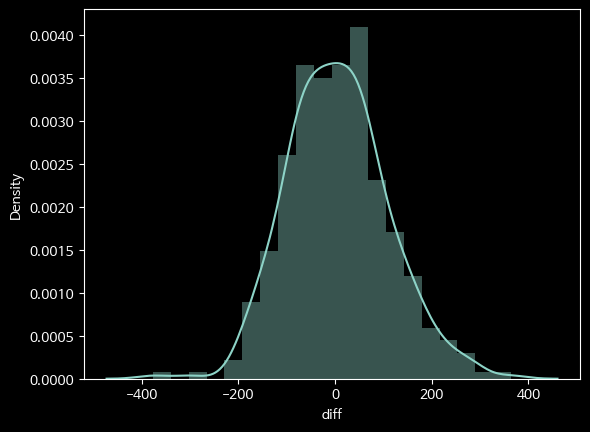

In [54]:
sns.distplot(result['diff'])

In [55]:
# 200 이상 diff에 대한 비중 분석
len(result[abs(result['diff']) >200])/len(result)

0.04696132596685083

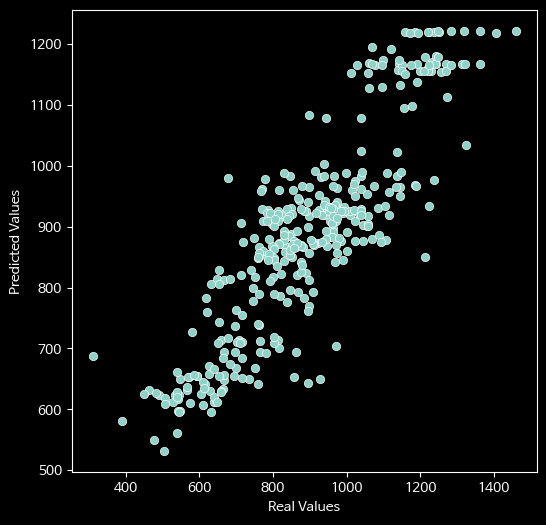

In [56]:
# test set 적절하게 fitting되어있음
sns.scatterplot(x=result['Real Values'], y=result['Predicted Values'])
plt.gcf().set_size_inches(6,6)

### 중요변수파악
---

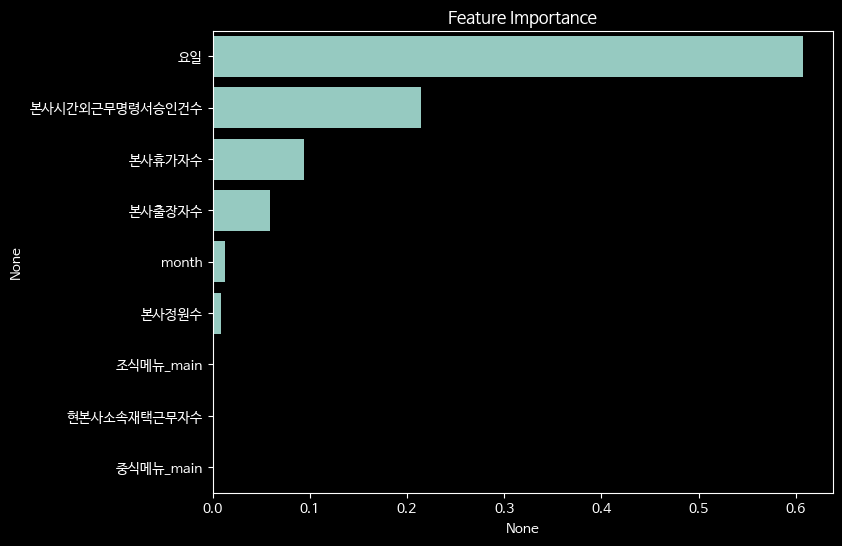

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use(['dark_background'])

ftr_importances_values = rfr.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importance')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [58]:
# 요일에 따라 중식 영향을 미치는 것은 상식적이며, 중식 식수 예측 상황을 보면 조식메뉴_main이 상위에 올라
# 조식메뉴_main에 따른 식수 인원 탐색
df.groupby('조식메뉴_main')['중식계'].mean().sort_values(ascending=False).head(10)

조식메뉴_main
모닝롤/고구마오븐구이          1329.000000
모닝롤/(New)오리훈제샌드위치    1324.000000
모카카스테라/베이글           1298.000000
모닝롤/롤케이크             1286.000000
모닝롤/증편               1257.000000
모닝롤/소보로빵             1256.000000
모닝롤/생크림와플            1254.000000
모닝롤/바나나팬케익           1248.666667
모닝롤/후르츠팬케익           1242.333333
모닝롤/파운드케익            1233.500000
Name: 중식계, dtype: float64

In [59]:
# 특별한 차이는 없어보임
df.groupby('조식메뉴_main')['중식계'].mean().sort_values(ascending=False).tail(10)

조식메뉴_main
모닝롤/대만식연유샌드위치     594.0
모닝롤/블루베리사과샌드      591.0
모닝롤/케익            573.0
모닝롤/미니케익          565.0
모닝롤/모닝샌드          527.0
모닝롤/팥호빵           520.0
모닝롤/계란빵           477.0
모닝롤/마약토스트         476.0
모닝롤/스콘            450.0
모닝롤/블루베리프렌치토스트    398.0
Name: 중식계, dtype: float64